In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from glob import glob
import seaborn as sns

from PIL import Image
np.random.seed(123)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

import shutil
import itertools

from numpy.random import seed
seed(101)
import tensorflow as tf
tf.compat.v1.set_random_seed(101)

import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
cd sample_data

In [0]:
mkdir data

In [0]:
cd data

In [0]:
!wget 'https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip'

In [0]:
!unzip ISIC_2019_Training_Input.zip && rm ISIC_2019_Training_Input.zip

In [0]:
cd ..

In [0]:
root_path = './data/'
train_path = './data/ISIC_2019_Training_Input'

In [0]:
base_dir = 'base_dir'
os.mkdir(base_dir)
## 9 Diagnostic Categories of Skin Cancer

# Melanoma -> MEL
# Melanocytic nevus -> NV
# Basal cell carcinoma -> BCC
# Actinic keratosis -> AK
# Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis) -> BKL
# Dermatofibroma -> DF
# Vascular lesion -> VASC
# Squamous cell carcinoma -> SCC
# None of the others -> UNK
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)


val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

nv = os.path.join(train_dir, 'NV')
os.mkdir(nv)
mel = os.path.join(train_dir, 'MEL')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'BKL')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'BCC')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'AK')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'VASC')
os.mkdir(vasc)
df = os.path.join(train_dir, 'DF')
os.mkdir(df)
df = os.path.join(train_dir, 'SCC')
os.mkdir(df)
df = os.path.join(train_dir, 'UNK')
os.mkdir(df)

nv = os.path.join(val_dir, 'NV')
os.mkdir(nv)
mel = os.path.join(val_dir, 'MEL')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'BKL')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'BCC')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'AK')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'VASC')
os.mkdir(vasc)
df = os.path.join(val_dir, 'DF')
os.mkdir(df)
df = os.path.join(val_dir, 'SCC')
os.mkdir(df)
df = os.path.join(val_dir, 'UNK')
os.mkdir(df)

In [0]:
metadata_path = './data/ISIC_2019_Training_Metadata.csv'
df_meta = pd.read_csv(metadata_path)
df_meta.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [0]:
gt_path = './data/ISIC_2019_Training_GroundTruth.csv'
df_gt = pd.read_csv(gt_path)
df_gt.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_cell_type = pd.DataFrame([x for x in np.where(df_gt == 1, df_gt.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))

In [0]:
df = pd.concat([df_meta, df_cell_type], axis=1, join='inner')
df.head()

,image,age_approx,anatom_site_general,lesion_id,sex,dx
0,ISIC_0000000,55.0,anterior torso,NaN,female,NV
1,ISIC_0000001,30.0,anterior torso,NaN,female,NV
2,ISIC_0000002,60.0,upper extremity,NaN,female,MEL
3,ISIC_0000003,30.0,upper extremity,NaN,male,NV
4,ISIC_0000004,80.0,posterior torso,NaN,male,MEL


In [0]:
df.isnull().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dx                        0
dtype: int64

In [0]:
df['age_approx'].fillna((df['age_approx'].mean()), inplace=True)

In [0]:
df.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
df.isnull().sum()

image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dx                     0
dtype: int64

In [0]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(root_path, '*', '*.jpg'))}

lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC': 'Squamous cell carcinoma',
    'UNK': 'None of the others'
}






df['path'] = df['image'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.tail()

,image,age_approx,anatom_site_general,lesion_id,sex,dx,path,cell_type,cell_type_idx
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,./data/ISIC_2019_Training_Input/ISIC_0073247.jpg,Basal cell carcinoma,1
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,./data/ISIC_2019_Training_Input/ISIC_0073248.jpg,Benign keratosis-like lesions,2
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,./data/ISIC_2019_Training_Input/ISIC_0073249.jpg,Melanoma,5
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,./data/ISIC_2019_Training_Input/ISIC_0073251.jpg,Melanocytic nevi,4
25330,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,./data/ISIC_2019_Training_Input/ISIC_0073254.jpg,Benign keratosis-like lesions,2


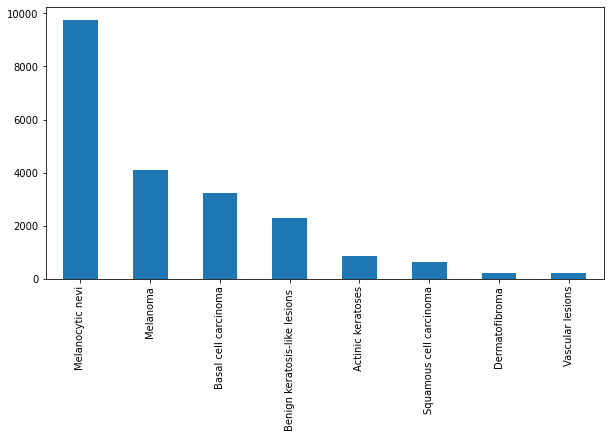

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

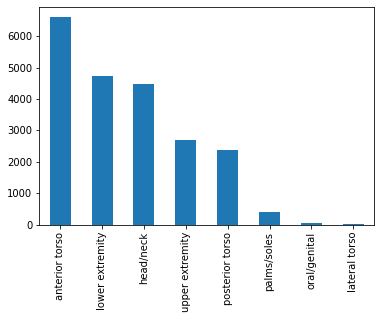

In [0]:
df['anatom_site_general'].value_counts().plot(kind='bar')

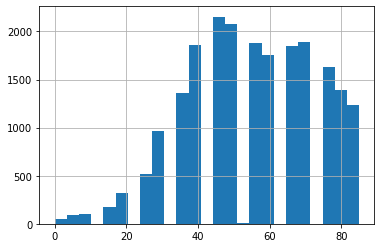

In [0]:
df['age_approx'].hist(bins=25)

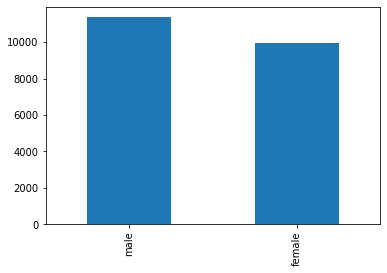

In [0]:
df['sex'].value_counts().plot(kind='bar')

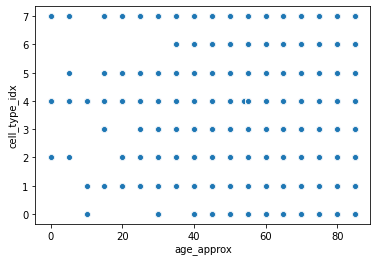

In [0]:
sns.scatterplot('age_approx','cell_type_idx', data=df)

In [0]:
df_ = df.groupby('lesion_id').count()

df_ = df_[df_['image'] == 1]

df_.reset_index(inplace=True)

df_.head()

,lesion_id,image,age_approx,anatom_site_general,sex,dx,path,cell_type,cell_type_idx
0,BCN_0000013,1,1,1,1,1,1,1,1
1,BCN_0000020,1,1,1,1,1,1,1,1
2,BCN_0000039,1,1,1,1,1,1,1,1
3,BCN_0000053,1,1,1,1,1,1,1,1
4,BCN_0000059,1,1,1,1,1,1,1,1


In [0]:
def identify_duplicates(x):
    
    unique_list = list(df_['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df['duplicates'] = df['lesion_id']
# apply the function to this new column
df['duplicates'] = df['duplicates'].apply(identify_duplicates)
df.tail()

,image,age_approx,anatom_site_general,lesion_id,sex,dx,path,cell_type,cell_type_idx,duplicates
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,./data/ISIC_2019_Training_Input/ISIC_0073247.jpg,Basal cell carcinoma,1,has_duplicates
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,./data/ISIC_2019_Training_Input/ISIC_0073248.jpg,Benign keratosis-like lesions,2,has_duplicates
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,./data/ISIC_2019_Training_Input/ISIC_0073249.jpg,Melanoma,5,has_duplicates
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,./data/ISIC_2019_Training_Input/ISIC_0073251.jpg,Melanocytic nevi,4,has_duplicates
25330,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,./data/ISIC_2019_Training_Input/ISIC_0073254.jpg,Benign keratosis-like lesions,2,has_duplicates


In [0]:
df['duplicates'].value_counts()

has_duplicates    15959
no_duplicates      5357
Name: duplicates, dtype: int64

In [0]:
df_ = df[df['duplicates'] == 'no_duplicates']

df_.shape

(5357, 10)

In [0]:
y = df_['dx']

_, df_val = train_test_split(df_, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(911, 10)

In [0]:
df_val['dx'].value_counts()

NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: dx, dtype: int64

In [0]:
def identify_val_rows(x):

    val_list = list(df_val['image'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

df['train_or_val'] = df['image']

df['train_or_val'] = df['train_or_val'].apply(identify_val_rows)
   

df_train = df[df['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

20405
911


In [0]:
df_train['dx'].value_counts()

NV      9128
MEL     4027
BCC     3185
BKL     2188
AK       831
SCC      604
DF       228
VASC     214
Name: dx, dtype: int64

In [0]:
df_val['dx'].value_counts()

NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: dx, dtype: int64

In [0]:
df.set_index('image', inplace=True)

In [0]:
folder = os.listdir(train_path)

train_list = list(df_train['image'])
val_list = list(df_val['image'])



for image in train_list:
    
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    
    if fname in folder:
        src = os.path.join(train_path, fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)


for image in val_list:
    
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    
    if fname in folder:
        src = os.path.join(train_path, fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

In [0]:
class_list = ['MEL', 'BKL', 'BCC', 'AK', 'VASC', 'DF', 'SCC']

for item in class_list:
    

    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item


    img_list = os.listdir('base_dir/train_dir/' + img_class)

    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)


    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)


    
    num_aug_images_wanted = 9200 

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    shutil.rmtree('aug_dir')

Found 4027 images belonging to 1 classes.
Found 2188 images belonging to 1 classes.
Found 3185 images belonging to 1 classes.
Found 831 images belonging to 1 classes.
Found 214 images belonging to 1 classes.
Found 228 images belonging to 1 classes.
Found 604 images belonging to 1 classes.


In [0]:
!rm -r ./data/ISIC_2019_Training_Input

In [0]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)

train_batch_size = 20
val_batch_size = 20

# image_size = 224
image_size = 299

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [0]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.xception.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 70774 images belonging to 9 classes.
Found 911 images belonging to 9 classes.
Found 911 images belonging to 9 classes.


In [0]:
mobile = keras.applications.xception.Xception()

91889664/91884032 [==============================] - 3s 0us/step


In [0]:
x = mobile.layers[-2].output

x = Dropout(0.25)(x)
predictions = Dense(9, activation='softmax')(x)



model = Model(inputs=mobile.input, outputs=predictions)

In [0]:
for layer in model.layers[:-134]:
    layer.trainable = False

In [0]:
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [0]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [0]:
print(valid_batches.class_indices)

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'UNK': 7, 'VASC': 8}


In [0]:
class_weights = {
    0: 1.0,  # AK
    1: 1.0,  # BCC
    2: 1.0,  # BKL
    3: 1.0,  # DF
    4: 3.0,  # MEL # Try to make the model more sensitive to Melanoma.
    5: 1.0,  # NV
    6: 1.0,  # SCC
    7: 1.0, 
    
    
    
     # UNK
    8: 1.0,  # VASC
}

In [0]:
filepath = "xception-134-trial03.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/30
1021/1021 [==============================] - 718s 703ms/step - loss: 2.2200 - categorical_accuracy: 0.2228 - top_2_accuracy: 0.4248 - top_3_accuracy: 0.5722 - val_loss: 1.7221 - val_categorical_accuracy: 0.5554 - val_top_2_accuracy: 0.6070 - val_top_3_accuracy: 0.6861

Epoch 00001: val_top_3_accuracy improved from -inf to 0.68606, saving model to xception-134-trial03.h5
Epoch 2/30
1021/1021 [==============================] - 695s 681ms/step - loss: 1.9367 - categorical_accuracy: 0.3420 - top_2_accuracy: 0.5581 - top_3_accuracy: 0.6948 - val_loss: 0.8622 - val_categorical_accuracy: 0.6454 - val_top_2_accuracy: 0.7662 - val_top_3_accuracy: 0.8683

Epoch 00002: val_top_3_accuracy improved from 0.68606 to 0.86828, saving model to xception-134-trial03.h5
Epoch 3/30
1021/1021 [==============================] - 695s 681ms/step - loss: 1.8006 - categorical_accuracy: 0.3938 - top_2_accuracy: 0.6072 - top_3_accuracy: 0.7398 - val_loss: 3.6507 - val_categorical_accuracy: 0.4665 - val_t

In [0]:
# get the metric names so we can use evaulate_generator
model.metrics_names

SyntaxError: ignored

In [0]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 2.2282605171203613
val_cat_acc: 0.7969264388084412
val_top_2_acc: 0.9099889993667603
val_top_3_acc: 0.9626783728599548


In [0]:
model.load_weights('xception-134-trial03.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 2.127767562866211
val_cat_acc: 0.7892425656318665
val_top_2_acc: 0.9143797755241394
val_top_3_acc: 0.9659714698791504


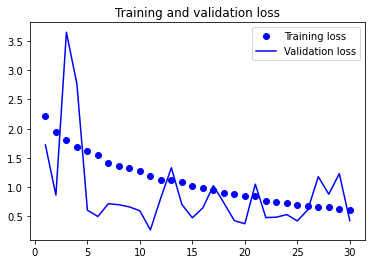

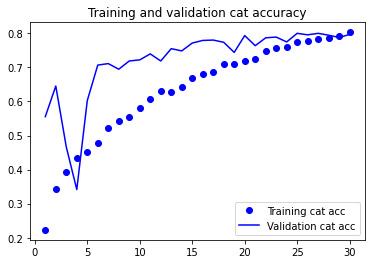

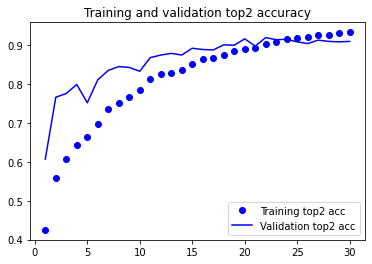

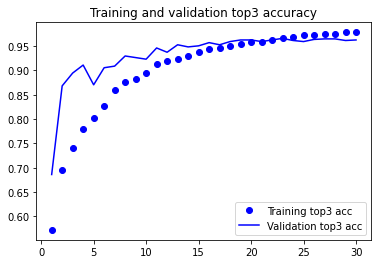

In [0]:

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()



plt.show()

In [0]:
test_labels = test_batches.classes

In [0]:
test_batches.class_indices

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'MEL': 4,
 'NV': 5,
 'SCC': 6,
 'UNK': 7,
 'VASC': 8}

In [0]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

911/911 [==============================] - 19s 21ms/step


In [0]:
predictions.shape

(911, 9)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
test_labels.shape

(911,)

In [0]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [0]:
test_batches.class_indices

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'MEL': 4,
 'NV': 5,
 'SCC': 6,
 'UNK': 7,
 'VASC': 8}

Confusion matrix, without normalization
[[  3   2   1   0   7   0   1   0]
 [  1  44   0   0   5   7   3   0]
 [  1   3  43   1  22  35   2   0]
 [  0   0   0   1   0   5   1   0]
 [  2   1   1   0  50  20   0   0]
 [  0   4   6   1  42 569   0   1]
 [  1   1   1   0   5   6   4   0]
 [  0   0   0   0   0   3   0   5]]


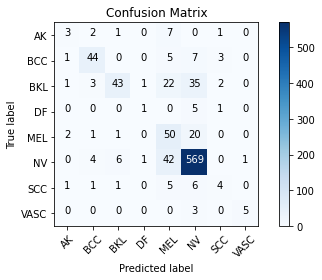

In [0]:
cm_plot_labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [0]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_batches.classes

In [0]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
balanced = balanced_accuracy_score(y_true, y_pred)
print(balanced)
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)
print(report)

0.4910707349595436
              precision    recall  f1-score   support

          AK       0.38      0.21      0.27        14
         BCC       0.80      0.73      0.77        60
         BKL       0.83      0.40      0.54       107
          DF       0.33      0.14      0.20         7
         MEL       0.38      0.68      0.49        74
          NV       0.88      0.91      0.90       623
         SCC       0.36      0.22      0.28        18
        VASC       0.83      0.62      0.71         8

    accuracy                           0.79       911
   macro avg       0.60      0.49      0.52       911
weighted avg       0.81      0.79      0.78       911

